# Tutorial 2: Medição da temperatura da superfície do mar - comparando métodos *in situ* e por satelites

### Importando bibliotecas

In [2]:
from netCDF4 import Dataset                # Read / Write NetCDF4 files
import matplotlib.pyplot as plt            # Plotting library
from datetime import datetime, timedelta   # Basic date and time types
import cartopy, cartopy.crs as ccrs        # Plot maps
import cartopy.feature as cfeature         # Common drawing and filtering operations
import cartopy.io.shapereader as shpreader # Import shapefiles
import numpy as np                         # Import the Numpy package
import matplotlib.colors                   # Matplotlib colors
from datetime import datetime, timedelta   # Basic Dates and time types
import os                                  # Miscellaneous operating system interfaces
import time as t                           # Time access and conversion
from noaa_ftp import NOAA
import xarray as xr

### Definindo funções


In [144]:
def pirata(nome_arquivo, date_formatted, data, plot):
    # Read the buoy data
    boia1 = xr.open_dataset(nome_arquivo)
    try: 
        data_selecionada = boia1.sel(time=date_formatted, method='nearest')
    except:
        data_selecionada = boia1.sel(time=date_formatted)
    temp_buoy = [np.nan if data_selecionada.temperature.sel(depth_t=0, method='nearest').values.round(2) == -9999.0 else data_selecionada.temperature.sel(depth_t=0, method='nearest').values.round(2)] 
    lon_buoy  = data_selecionada.longitude.values - 360
    lat_buoy  = data_selecionada.latitude.values

    temp_sat = data.sel(lat=lat_buoy, lon=lon_buoy, method='nearest').values

    delta = temp_sat - temp_buoy

    if plot == 'sim':
        # Adding Annotations
        ax.plot(lon_buoy, lat_buoy, 'o', color='red', markersize=8, transform=ccrs.Geodetic(), markeredgewidth=1.0, markeredgecolor=(0, 0, 0, 1))
        text = "Lat: " + str(lat_buoy.round(2)) + "\n" + "Lon: " + str(lon_buoy.round(2)) + "\n" + "Satellite: " + str(temp_sat) + " °C" + "\n" + "Buoy: " + str(temp_buoy) + " °C" + "\n" + "\u0394 = "  + str(delta.round(4)) + " °C"
        plt.annotate(text, xy=(int(lon_buoy + txt_offset_x), int(lat_buoy + txt_offset_y)), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), fontsize=12, fontweight='bold', color='gold', bbox=dict(boxstyle="round",fc=(0.0, 0.0, 0.0, 0.5), ec=(1., 1., 1.)), alpha = 1.0)
    else:
        print('Temepratura boia: ', np.round(temp_buoy[0],2))
        print('Temepratura satélite: ', np.round(temp_sat,2))
        print('Diferença: ',np.round(delta[0],2))

### Objetivos do Tutorial

Neste tutorial, você aprenderá a obter dados da temperatura da superfície do mar (TSM) de forma prática e eficiente. Usaremos a biblioteca noaa_ftp para fazer o download dos dados diretamente do site da [NOAA](https://www.noaa.gov/). Além disso, você acessará dados de boias do Projeto PIRATA, realizará uma comparação entre as temperaturas obtidas por satélite e as medições in situ, e criará uma visualização gráfica dessas informações. Os objetivos específicos são:

1. Baixar dados de TSM do site da NOAA utilizando a biblioteca `noaa_ftp`.
2. Obter dados de boias do Projeto PIRATA
3. Comparar as temperaturas de TSM entre os dados de satélite e as medições *in situ* das boias.
4. Plotar uma figura espacial do Atlântico Equatorial com a comparação das diferentes fontes de dados.

Ao concluir este tutorial, você estará apto a identificar e analisar as diferenças entre as medições diretas e indiretas da TSM.

### Oceanografia por Satélite: Avanços e Importância

A oceanografia por satélite revolucionou a forma como estudamos e compreendemos os oceanos. Utilizando sensores remotos a bordo de satélites, os cientistas conseguem monitorar vastas áreas oceânicas em tempo real, algo que seria impossível apenas com medições in situ. Essa tecnologia tem permitido avanços significativos em diversas áreas, como a climatologia, a modelagem de correntes oceânicas, e a previsão de fenômenos extremos como furacões e tsunamis.

Avanços Provocados pela Oceanografia por Satélite

 - Monitoramento Global e Contínuo: A capacidade de observar os oceanos de forma contínua e em escala global é um dos maiores avanços. Isso permite que os cientistas acompanhem mudanças sazonais e a longo prazo, contribuindo para o entendimento das dinâmicas oceânicas e seus impactos no clima global.

 - Modelagem de Correntes e Dinâmicas Oceânicas: Dados de satélite ajudam na modelagem precisa de correntes oceânicas, como a Corrente do Golfo
 
 - Previsão do ENSO: os dados de satélite são muito utilizados para compreender, inferir e até mesmo prever eventos como El Niño e La Niña.

 - Monitoramento da Saúde dos Oceanos: Sensores de satélite permitem a análise da saúde dos oceanos através da medição de parâmetros como a clorofila-a, que indica a produtividade biológica e a presença de algas marinhas.

#### Seção 1: Temperatura da Superfície do Mar (TSM)

Uma das aplicações mais importantes da oceanografia por satélite é a medição da temperatura da superfície do mar (TSM). Esta informação é crucial para o entendimento das interações entre o oceano e a atmosfera, influenciando previsões climáticas e meteorológicas.

A TSM é obtida através de radiômetros de infravermelho e micro-ondas a bordo de satélites. Esses sensores detectam a radiação emitida pela superfície do oceano, que é então convertida em valores de temperatura. A TSM é um dos principais fatores na previsão de ciclones tropicais, correntes oceânicas e eventos climáticos globais como ENSO. Além disso, mudanças na SST são indicadores-chave das mudanças climáticas.

O projeto [Coral Reef Watch](https://coralreefwatch.noaa.gov/product/5km/index_5km_ssta.php) (CRW) da NOAA fornece um conjunto de produtos diários globais de TSM em uma resolução de 5 km, conhecido como CoralTemp, abrangendo desde 1985 até o presente. Esses produtos são essenciais para o monitoramento do estresse térmico relacionado ao branqueamento de corais, especialmente em regiões com alta variabilidade térmica. A v3.1 foi desenvolvida para corrigir erros em dados anteriores e agora permite o monitoramento direto de 95% dos recifes de corais globais, reduzindo lacunas de dados causadas pela cobertura de nuvens.

Entre os produtos oferecidos estão a TSM, Anomalia de TSM, HotSpot de Branqueamento de Corais, e a Tendência de TSM de 7 dias. O produto de Tendência de TSM, por exemplo, analisa a variação da TSM ao longo de sete dias, identificando tendências significativas que podem indicar estresse térmico em corais. Esses dados são atualizados diariamente, proporcionando informações críticas para a gestão de recifes de corais e a previsão de eventos de branqueamento.

In [73]:
from noaa_ftp import NOAA
# today = datetime.now()
delay = 0
today = datetime(2022,4,9)

path = ('pub/socd/mecb/crw/data/5km/v3.1_op/nc/v1.0/daily/sst/' + (today + timedelta(days=delay)).strftime('%Y') + '/')
naming_convention = 'coraltemp_v3.1'
extension = '.nc'
file_name = naming_convention + '_' + (today + timedelta(days=delay)).strftime('%Y%m%d') + extension
print('Salvando o arquivo: ', file_name)

noaa = NOAA("ftp.star.nesdis.noaa.gov", path).download(file_name)

Salvando o arquivo:  coraltemp_v3.1_20220409.nc


Downloading:   0% [                                  ] ETA:  --:--:--   0.0 s/B
Downloading:   0% [                                ] ETA:   0:13:42  13.7 KiB/s
Downloading:   0% [                                ] ETA:   0:06:11  30.2 KiB/s
Downloading:   0% [                                ] ETA:   0:03:16  57.1 KiB/s
Downloading:   0% [                                ] ETA:   0:01:49 102.3 KiB/s
Downloading:   1% [                                ] ETA:   0:01:00 183.2 KiB/s
Downloading:   3% [#                               ] ETA:   0:00:33 326.7 KiB/s
Downloading:   7% [##                              ] ETA:   0:00:17 588.0 KiB/s
Downloading:  11% [###                             ] ETA:   0:00:11 860.2 KiB/s
Downloading:  15% [####                            ] ETA:   0:00:08   1.1 MiB/s
Downloading:  20% [######                          ] ETA:   0:00:06   1.4 MiB/s
Downloading:  24% [#######                         ] ETA:   0:00:05   1.5 MiB/s
Downloading:  36% [###########          

In [74]:
ds = xr.open_dataset(file_name)
ds

<xarray.Dataset> Size: 415MB
Dimensions:           (lat: 3600, lon: 7200, time: 1)
Coordinates:
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 8B 2022-04-09T12:00:00
Data variables:
    analysed_sst      (time, lat, lon) float64 207MB ...
    sea_ice_fraction  (time, lat, lon) float64 207MB ...
    crs               int16 2B ...
Attributes: (12/58)
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    contributor_name:           NOAA Coral Reef Watch Program
    contributor_role:           Collecting source data and deriving products;...
    Conventions:                CF-1.6, ACDD-1.3
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          20220410T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        20220409T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       36c339e6-c901-11e7-8a08-38d54702cff0

#### Acurácia do satélite

A acurácia das medições de TSM por satélite é impressionante, especialmente considerando a escala global das observações. As medições de TSM têm uma precisão tipicamente na ordem de ±0,3°C a ±0,5°C. Essa alta precisão é suficiente para detectar mudanças sutis que podem ter grandes impactos climáticos. Apesar da alta acurácia, a presença de nuvens pode interferir nas medições de radiômetros de infravermelho, exigindo o uso de micro-ondas em áreas cobertas por nuvens. Mesmo assim, os dados obtidos são essenciais e complementados por medições in situ para validação.

In [145]:
data = (ds.analysed_sst.sel(lat=slice(-30, 50), lon=slice(-70, 10))).squeeze(dim='time')
date_formatted = (((ds.time).to_dataframe().index)[0]).strftime('%Y-%m-%d')
pirata('http://goosbrasil.org:8080/pirata/B20n38w.nc', date_formatted, data,'nao')

Temepratura boia:  23.83
Temepratura satélite:  23.88
Diferença:  0.05


### Seção 2: Plot espacial da TSM do Atlântico Equatorial

C:\Users\elisa\AppData\Local\Temp\ipykernel_22016\801737384.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.annotate(text, xy=(int(lon_buoy + txt_offset_x), int(lat_buoy + txt_offset_y)), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), fontsize=12, fontweight='bold', color='gold', bbox=dict(boxstyle="round",fc=(0.0, 0.0, 0.0, 0.5), ec=(1., 1., 1.)), alpha = 1.0)


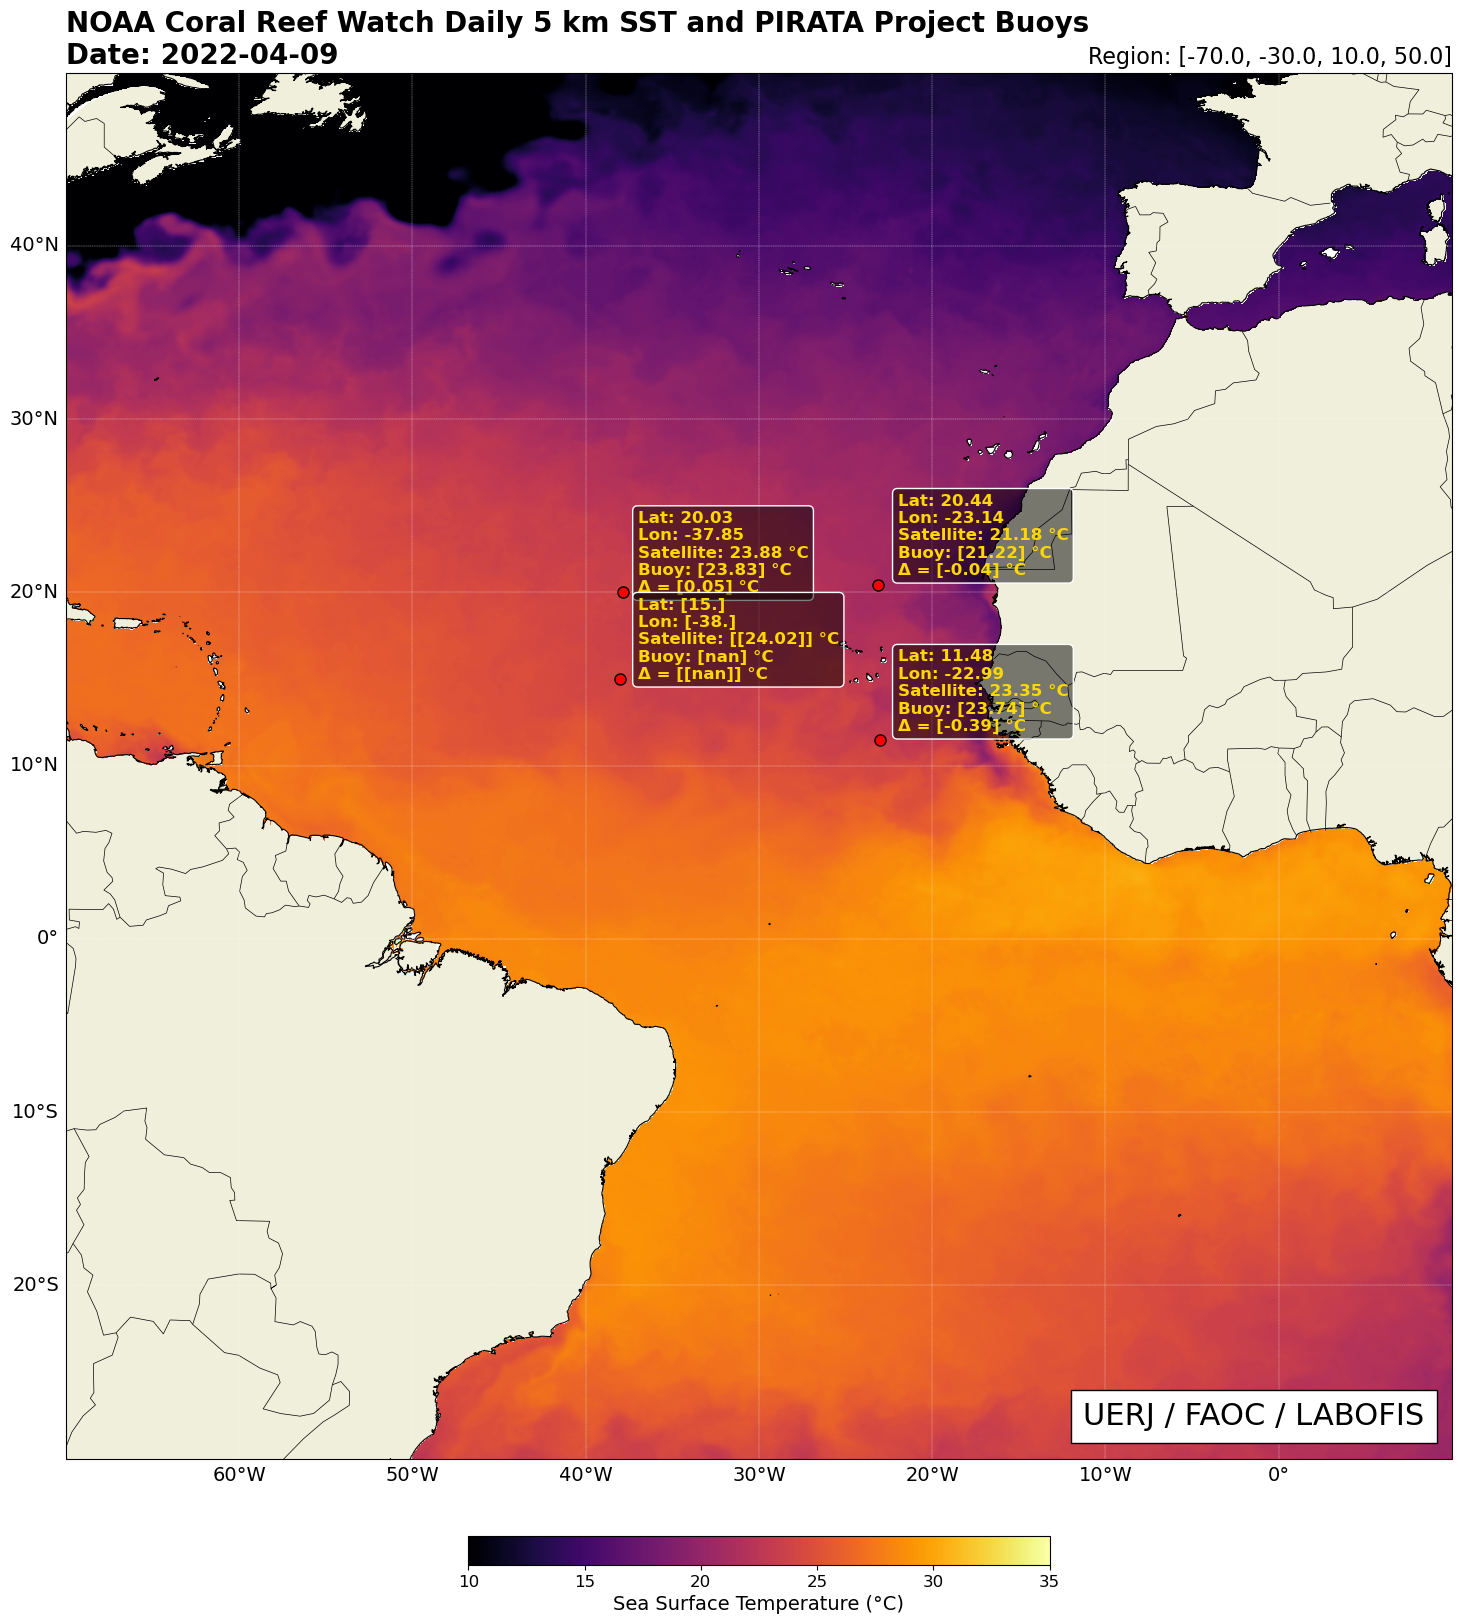

In [146]:
#---------------------------------------------------------------------------------------------------------------------------
# Select the extent [min. lon, min. lat, max. lon, max. lat]
extent = [-70.0, -30.00, 10.00, 50.00] # Atlantico Equatorial

# Extract the Sea Surface Temperature
data = (ds.analysed_sst.sel(lat=slice(-30, 50), lon=slice(-70, 10))).squeeze(dim='time')

# data = file.variables['analysed_sst'][ 0 , latli:latui , lonli:lonui ]
#---------------------------------------------------------------------------------------------------------------------------
# Choose the plot size (width x height, in inches)
plt.figure(figsize=(25,20))

# Use the Cilindrical Equidistant projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='black', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='white', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': 14, 'color': 'black'}  # Set font size to 14 and color to black
gl.ylabel_style = {'size': 14, 'color': 'black'}  # Set font size to 14 and color to black

vmin = 10.0
vmax = 35.0

# Add a land mask
ax.add_feature(cfeature.LAND)

# Plot the image
img = ax.imshow(data, vmin=vmin, vmax=vmax, origin='lower', extent=img_extent, cmap='inferno')

# Add a colorbar
CB2 = plt.colorbar(img, extend='neither',\
                          orientation='horizontal', pad=0.05, fraction=0.05, shrink=0.3)
CB2.set_label('Sea Surface Temperature (°C)', fontsize=14)
CB2.ax.tick_params(labelsize='large')

# Getting the file time and date
date_formatted = (((ds.time).to_dataframe().index)[0]).strftime('%Y-%m-%d')

# Add a title
# plt.title(f'NOAA Coral Reef Watch Daily 5 km SST + PIRATA Project Buoys - {date_formatted}', fontweight='bold', fontsize=20, loc='left')
plt.title(f'NOAA Coral Reef Watch Daily 5 km SST and PIRATA Project Buoys  \nDate: {date_formatted}', fontweight='bold', fontsize=20, loc='left')
plt.title('Region: ' + str(extent), fontsize=16, loc='right')

# Add a text inside the plot
from matplotlib.offsetbox import AnchoredText
text = AnchoredText("UERJ / FAOC / LABOFIS", loc=4, prop={'size': 22}, frameon=True)
ax.add_artist(text)


txt_offset_x = 0.8
txt_offset_y = 0.8
date_formatted = (((ds.time).to_dataframe().index)[0]).strftime('%Y-%m-%d')

pirata('http://goosbrasil.org:8080/pirata/B20n38w.nc', date_formatted, data,'sim')
pirata('http://goosbrasil.org:8080/pirata/B15n38w.nc', date_formatted, data,'sim')
pirata('http://goosbrasil.org:8080/pirata/B21n23w.nc', date_formatted, data,'sim')
pirata('http://goosbrasil.org:8080/pirata/B12n23w.nc', date_formatted, data,'sim')

plt.show()

### Desafio:

Faça essa mesma figura para outro dia e com mais boias!

In [ ]:
delay = 0
today = datetime(yyyy,mm,dd)

path = ('pub/socd/mecb/crw/data/5km/v3.1_op/nc/v1.0/daily/sst/' + (today + timedelta(days=delay)).strftime('%Y') + '/')
naming_convention = 'coraltemp_v3.1'
extension = '.nc'
file_name = naming_convention + '_' + (today + timedelta(days=delay)).strftime('%Y%m%d') + extension
print('Salvando o arquivo: ', file_name)

noaa = NOAA("ftp.star.nesdis.noaa.gov", path).download(file_name)

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------
# Select the extent [min. lon, min. lat, max. lon, max. lat]
extent = [-70.0, -30.00, 10.00, 50.00] # Atlantico Equatorial

# Extract the Sea Surface Temperature
data = (ds.analysed_sst.sel(lat=slice(-30, 50), lon=slice(-70, 10))).squeeze(dim='time')

# data = file.variables['analysed_sst'][ 0 , latli:latui , lonli:lonui ]
#---------------------------------------------------------------------------------------------------------------------------
...
